# CS231a PSET 2

You can use this colab notebook to write your code in, which could save you the trouble of having to set up Python or installing packages.

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

# # Enter the foldername in your Drive where you have saved the unzipped
# # the files containing the 'data' folder and epipolar_utils.py and sfm_utils.py
# # needed for this PSET
# # e.g. '/content/drive/MyDrive/cs231a/ps2_code'
# FOLDERNAME = 'cs231a/ps2_code'

# assert FOLDERNAME is not None, "[!] Enter the foldername."

# %cd drive/MyDrive/$FOLDERNAME
# print('Files in this folder:')
# %ls .

# Problem 1: Fundamental Matrix Estimation From Point Correspondences

Make sure you have run the code block above and have access to the data for this problem. Now, you can fill out the logic for this problem. Once done, copy it to p1.py for submission to Gradescope.

--------------------------------------------------------------------------------
Set: data/set1
--------------------------------------------------------------------------------
Fundamental Matrix from LLS  8-point algorithm:
 [[ 1.55218081e-06 -8.18161523e-06 -1.50440111e-03]
 [-5.86997052e-06 -3.02892219e-07 -1.13607605e-02]
 [-3.52312036e-03  1.41453881e-02  9.99828068e-01]]
Distance to lines in image 1 for LLS: 28.02566293758638
Distance to lines in image 2 for LLS: 25.16287580007875
p'^T F p = 0.03029585331320961
Fundamental Matrix from normalized 8-point algorithm:
 [[ 6.52113484e-07 -5.33615067e-06  8.80860210e-05]
 [-4.91237449e-06 -3.40420428e-07 -6.43807393e-03]
 [-8.56136054e-04  8.84208000e-03  1.45953063e-01]]
Distance to lines in image 1 for normalized: 0.8906416272438267
Distance to lines in image 2 for normalized: 0.8287729118221311


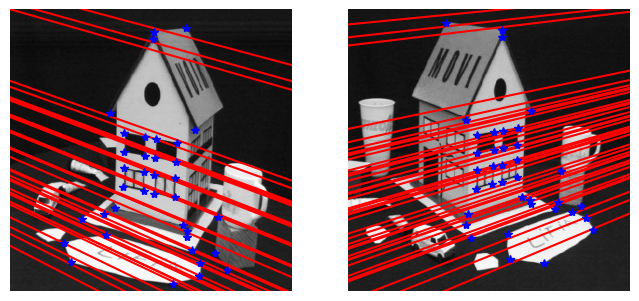

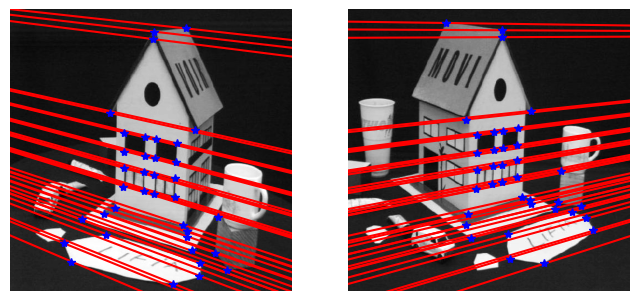

--------------------------------------------------------------------------------
Set: data/set2
--------------------------------------------------------------------------------
Fundamental Matrix from LLS  8-point algorithm:
 [[-5.63087200e-06  2.74976583e-05 -6.42650411e-03]
 [-2.77622828e-05 -6.74748522e-06  1.52182033e-02]
 [ 1.07623595e-02 -1.22519240e-02 -9.99730547e-01]]
Distance to lines in image 1 for LLS: 9.701438829446099
Distance to lines in image 2 for LLS: 14.568227190516716
p'^T F p = 0.033136691062293
Fundamental Matrix from normalized 8-point algorithm:
 [[-1.51007608e-07  2.51618737e-06 -1.56134009e-04]
 [ 3.63462620e-06  3.22311660e-07  7.02588719e-03]
 [ 2.36155133e-04 -8.53003408e-03 -2.45880925e-03]]
Distance to lines in image 1 for normalized: 0.8895134540568715
Distance to lines in image 2 for normalized: 0.8917343723800056


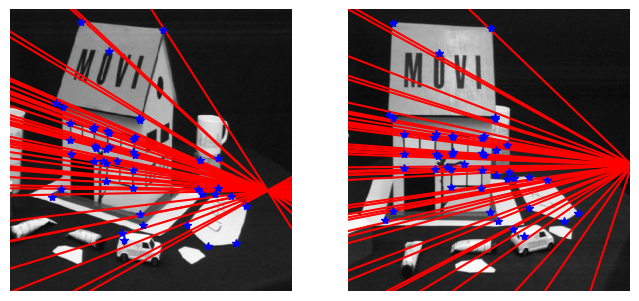

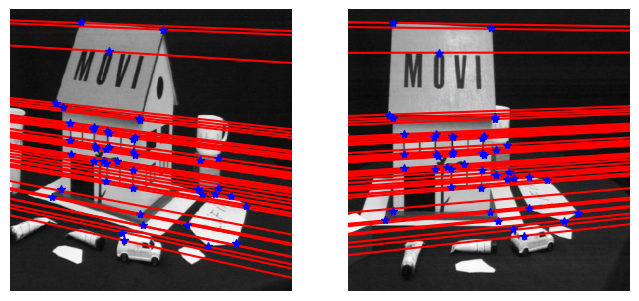

In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from epipolar_utils import *

'''
LLS_EIGHT_POINT_ALG  computes the fundamental matrix from matching points using 
linear least squares eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the linear least squares eight
point algorithm works
'''
def lls_eight_point_alg(points1, points2):
    # TODO: Implement this method!
    u1 = points1[:, 0]
    v1 = points1[:, 1]
    u1_p = points2[:, 0]
    v1_p = points2[:, 1]
    one = np.ones_like(u1)
    W = np.c_[u1 * u1_p, v1 * u1_p, u1_p, u1 * v1_p, v1 * v1_p, v1_p, u1, v1, one]
    # Use svd to find the lstsq solution for Wf = 0
    u, s, vh = np.linalg.svd(W, full_matrices=True)
    f = vh[-1, :]
    F_t = f.reshape(3, 3)
    # Enforce F_t to F which is rank 2
    u, s, vh = np.linalg.svd(F_t, full_matrices=True)
    s[-1] = 0
    F = u.dot(np.diag(s)).dot(vh)
    return F

'''
NORMALIZED_EIGHT_POINT_ALG  computes the fundamental matrix from matching points
using the normalized eight point algorithm
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    F - the fundamental matrix such that (points2)^T * F * points1 = 0
Please see lecture notes and slides to see how the normalized eight
point algorithm works
'''
def normalized_eight_point_alg(points1, points2):
    # TODO: Implement this method!
    # Find the transformation matrix T and T': [[S, S*t], [0, 1]], because we translate first, then scale
    # Translate: origin as image points centroid
    # Scale: 2 / mean squared distance
    mean1 = np.mean(points1, axis=0)
    mean2 = np.mean(points2, axis=0)
    
    scale1 = np.sqrt(2 / np.mean(np.sum((points1 - mean1) ** 2, axis=1)))
    scale2 = np.sqrt(2 / np.mean(np.sum((points2 - mean2) ** 2, axis=1)))
    T = np.array([[scale1, 0, -scale1 * mean1[0]], [0, scale1, -scale1 * mean1[1]], [0, 0 ,1]])
    T_p = np.array([[scale2, 0, -scale2 * mean2[0]], [0, scale2, -scale2 * mean2[1]], [0, 0, 1]])
    # q = T * p
    points1 = T.dot(points1.T).T
    points2 = T_p.dot(points2.T).T
    Fq = lls_eight_point_alg(points1, points2)
    # de-normalize
    return T_p.T.dot(Fq).dot(T)

'''
PLOT_EPIPOLAR_LINES_ON_IMAGES given a pair of images and corresponding points,
draws the epipolar lines on the images
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
    im1 - a HxW(xC) matrix that contains pixel values from the first image 
    im2 - a HxW(xC) matrix that contains pixel values from the second image 
    F - the fundamental matrix such that (points2)^T * F * points1 = 0

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    Nothing; instead, plots the two images with the matching points and
    their corresponding epipolar lines. See Figure 1 within the problem set
    handout for an example
'''
def plot_epipolar_lines_on_images(points1, points2, im1, im2, F):

    def plot_epipolar_lines_on_image(points1, points2, im, F):
        im_height = im.shape[0]
        im_width = im.shape[1]
        lines = F.T.dot(points2.T)
        plt.imshow(im, cmap='gray')
        for line in lines.T:
            a,b,c = line
            xs = [1, im.shape[1]-1]
            ys = [(-c-a*x)/b for x in xs]
            plt.plot(xs, ys, 'r')
        for i in range(points1.shape[0]):
            x,y,_ = points1[i]
            plt.plot(x, y, '*b')
        plt.axis([0, im_width, im_height, 0])

    # We change the figsize because matplotlib has weird behavior when 
    # plotting images of different sizes next to each other. This
    # fix should be changed to something more robust.
    new_figsize = (8 * (float(max(im1.shape[1], im2.shape[1])) / min(im1.shape[1], im2.shape[1]))**2 , 6)
    fig = plt.figure(figsize=new_figsize)
    plt.subplot(121)
    plot_epipolar_lines_on_image(points1, points2, im1, F)
    plt.axis('off')
    plt.subplot(122)
    plot_epipolar_lines_on_image(points2, points1, im2, F.T)
    plt.axis('off')

'''
COMPUTE_DISTANCE_TO_EPIPOLAR_LINES  computes the average distance of a set a 
points to their corresponding epipolar lines. Compute just the average distance
from points1 to their corresponding epipolar lines (which you get from points2).
Arguments:
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
    F - the fundamental matrix such that (points2)^T * F * points1 = 0

    Both points1 and points2 are from the get_data_from_txt_file() method
Returns:
    average_distance - the average distance of each point to the epipolar line
'''
def compute_distance_to_epipolar_lines(points1, points2, F):
    # TODO: Implement this method!
    l = F.T.dot(points2.T)
    # distance from point(x0, y0) to line: Ax + By + C = 0 is
    # |Ax0 + By0 + C| / sqrt(A^2 + B^2)
    d = np.mean(np.abs(np.sum(l * points1.T, axis=0)) / np.sqrt(l[0, :] ** 2 + l[1, :] ** 2))
    return d

if __name__ == '__main__':
    for im_set in ['data/set1', 'data/set2']:
        print('-'*80)
        print("Set:", im_set)
        print('-'*80)

        # Read in the data
        im1 = imread(im_set+'/image1.jpg')
        im2 = imread(im_set+'/image2.jpg')
        points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
        points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
        assert (points1.shape == points2.shape)

        # Running the linear least squares eight point algorithm
        F_lls = lls_eight_point_alg(points1, points2)
        print("Fundamental Matrix from LLS  8-point algorithm:\n", F_lls)
        print("Distance to lines in image 1 for LLS:", \
            compute_distance_to_epipolar_lines(points1, points2, F_lls))
        print("Distance to lines in image 2 for LLS:", \
            compute_distance_to_epipolar_lines(points2, points1, F_lls.T))

        # Running the normalized eight point algorithm
        F_normalized = normalized_eight_point_alg(points1, points2)

        pFp = [points2[i].dot(F_normalized.dot(points1[i])) 
            for i in range(points1.shape[0])]
        print("p'^T F p =", np.abs(pFp).max())
        print("Fundamental Matrix from normalized 8-point algorithm:\n", \
            F_normalized)
        print("Distance to lines in image 1 for normalized:", \
            compute_distance_to_epipolar_lines(points1, points2, F_normalized))
        print("Distance to lines in image 2 for normalized:", \
            compute_distance_to_epipolar_lines(points2, points1, F_normalized.T))

        # Plotting the epipolar lines
        plot_epipolar_lines_on_images(points1, points2, im1, im2, F_lls)
        plot_epipolar_lines_on_images(points1, points2, im1, im2, F_normalized)

        plt.show()


# Problem 2: Matching Homographies for Image Rectification

First, make sure you have access to the data. Then, complete this code and then copy it to p2.py for submission to Gradescope.

e1 [-1.30071143e+03 -1.42448272e+02  1.00000000e+00]
e2 [1.65412463e+03 4.53021078e+01 1.00000000e+00]
H1:
 [[-1.20006316e+01 -4.15501447e+00 -1.23476881e+02]
 [ 1.41006481e+00 -1.48704147e+01 -2.84177469e+02]
 [-9.21889298e-03 -2.19184511e-03 -1.23033440e+01]]
H2:
 [[ 8.09798131e-01 -1.22036874e-01  7.99331183e+01]
 [-3.00186699e-02  1.01581538e+00  3.63604348e+00]
 [-6.99360915e-04  1.05393946e-04  1.15205554e+00]]


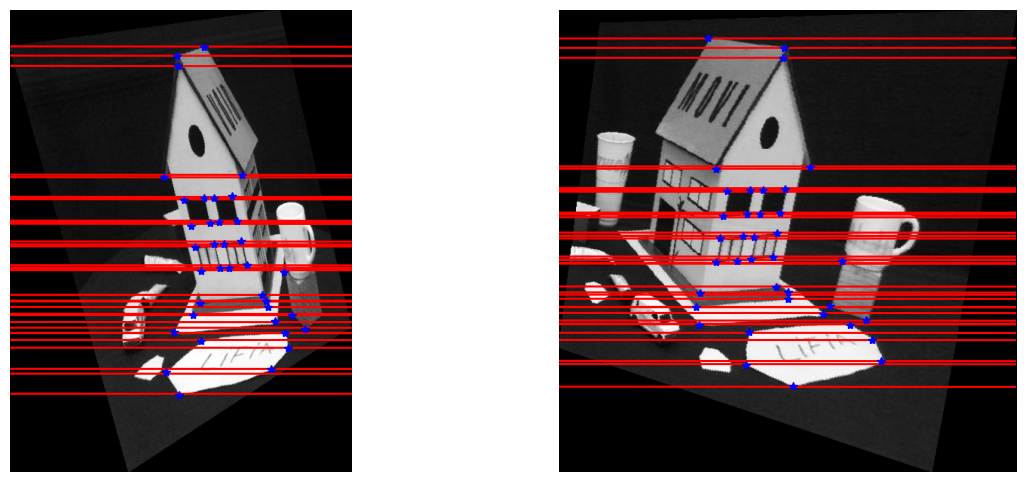

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from epipolar_utils import *

'''
COMPUTE_EPIPOLE computes the epipole e in homogenous coordinates
given the fundamental matrix
Arguments:
    F - the Fundamental matrix solved for with normalized_eight_point_alg(points1, points2)

Returns:
    epipole - the homogenous coordinates [x y 1] of the epipole in the image
'''
def compute_epipole(points1, points2, F):
    # TODO: Implement this method!
    # p.'T * F * p = 0
    l1 = F.T.dot(points2.T).T
    # Solve l1 * e = 0
    u, s, vh = np.linalg.svd(l1)
    e = vh[-1, :]
    e = e / e[2]
    return e

'''
COMPUTE_H computes a homography to map an epipole to infinity along the horizontal axis 
Arguments:
    e - the epipole
    im2 - the image
Returns:
    H - homography matrix
'''
def compute_H(e, im):
    # TODO: Implement this method!
    # raise Exception('Not Implemented Error')
    # 不需要这个函数
    pass

'''
COMPUTE_MATCHING_HOMOGRAPHIES determines homographies H1 and H2 such that they
rectify a pair of images
Arguments:
    e2 - the second epipole
    F - the Fundamental matrix
    im2 - the second image
    points1 - N points in the first image that match with points2
    points2 - N points in the second image that match with points1
Returns:
    H1 - the homography associated with the first image
    H2 - the homography associated with the second image
'''
def compute_matching_homographies(e2, F, im2, points1, points2):
    # TODO: Implement this method!
    h = im2.shape[0]
    w = im2.shape[1]
    T = np.array([[1, 0, -w/2], [0, 1, -h/2], [0, 0, 1]])
    e2_p = T.dot(e2)
    e2_p = e2_p / e2_p[2]
    e2x = e2_p[0]
    e2y = e2_p[1]
    if e2x >= 0:
        a = 1
    else:
        a = -1
    R1 = a * e2x / np.sqrt(e2x ** 2 + e2y ** 2)
    R2 = a * e2y / np.sqrt(e2x ** 2 + e2y ** 2)
    R = np.array([[R1, R2, 0], [-R2, R1, 0], [0, 0, 1]])
    e2_p = R.dot(e2_p)
    f = e2_p[0]
    G = np.array([[1, 0, 0], [0, 1, 0], [-1/f, 0, 1]])
    H2 = np.linalg.inv(T).dot(G).dot(R).dot(T)
    
    e_x = np.array([[0, -e2[2], e2[1]], [e2[2], 0, -e2[0]], [-e2[1], e2[0], 0]])
    M = e_x.dot(F) + e2.reshape(3,1).dot(np.array([[1, 1, 1]]))
    points1_t = H2.dot(M).dot(points1.T)
    points2_t = H2.dot(points2.T)
    points1_t /= points1_t[2, :]
    points2_t /= points2_t[2, :]
    b = points2_t[0, :]
    a = np.linalg.lstsq(points1_t.T, b, rcond=None)[0]
    H_A = np.array([a, [0, 1, 0], [0, 0, 1]])
    H1 = H_A.dot(H2).dot(M)
    return H1, H2

if __name__ == '__main__':
    # Read in the data
    im_set = 'data/set1'
    im1 = imread(im_set+'/image1.jpg')
    im2 = imread(im_set+'/image2.jpg')
    points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
    points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
    assert (points1.shape == points2.shape)

    F = normalized_eight_point_alg(points1, points2)
    # F is such that such that (points2)^T * F * points1 = 0, so e1 is e' and e2 is e
    e1 = compute_epipole(points1, points2, F)
    e2 = compute_epipole(points2, points1, F.transpose())
    print("e1", e1)
    print("e2", e2)

    # Find the homographies needed to rectify the pair of images
    H1, H2 = compute_matching_homographies(e2, F, im2, points1, points2)
    print("H1:\n", H1)
    print
    print("H2:\n", H2)

    # Transforming the images by the homographies
    new_points1 = H1.dot(points1.T)
    new_points2 = H2.dot(points2.T)
    new_points1 /= new_points1[2,:]
    new_points2 /= new_points2[2,:]
    new_points1 = new_points1.T
    new_points2 = new_points2.T
    rectified_im1, offset1 = compute_rectified_image(im1, H1)
    rectified_im2, offset2 = compute_rectified_image(im2, H2)
    new_points1 -= offset1 + (0,)
    new_points2 -= offset2 + (0,)

    # Plotting the image
    F_new = normalized_eight_point_alg(new_points1, new_points2)
    plot_epipolar_lines_on_images(new_points1, new_points2, rectified_im1, rectified_im2, F_new)
    plt.show()


# Problem 3: The Factorization Method

First, make sure you have access to the data. Then, complete this code and then copy it to p3.py for submission to Gradescope.

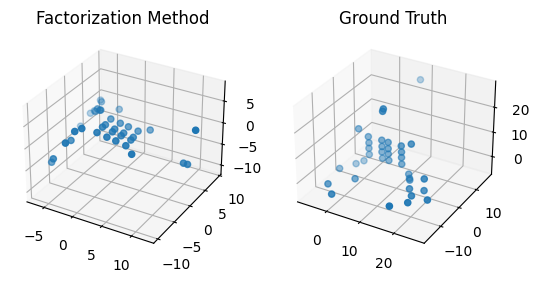

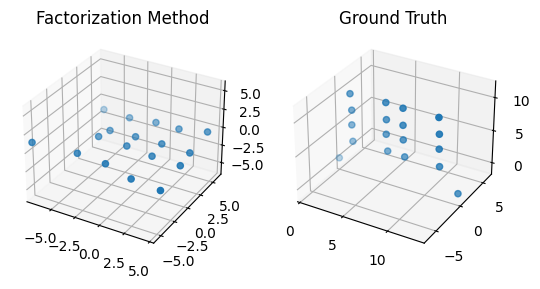

In [5]:
# PSET 2 Problem 3
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib.gridspec as gridspec
from epipolar_utils import *

'''
FACTORIZATION_METHOD The Tomasi and Kanade Factorization Method to determine
the 3D structure of the scene and the motion of the cameras.
Arguments:
    points_im1 - N points in the first image that match with points_im2
    points_im2 - N points in the second image that match with points_im1

    Both points_im1 and points_im2 are from the get_data_from_txt_file() method
Returns:
    structure - the structure matrix
    motion - the motion matrix
'''
def factorization_method(points_im1, points_im2):
    # TODO: Implement this method!
    p1_t = points_im1 - np.mean(points_im1, axis=0)
    p2_t = points_im2 - np.mean(points_im2, axis=0)
    D = np.c_[p1_t[:, 0: 2], p2_t[:, 0: 2]].T
    # D should be 4 × N
    u, s, vh = np.linalg.svd(D)
    u = u[:, 0: 3]
    vh = vh[0: 3, :]
    s = np.diag(s[0: 3])
    motion = np.dot(u, np.sqrt(s))
    structure = np.dot(np.sqrt(s), vh)
    return structure, motion

if __name__ == '__main__':
    for im_set in ['data/set1', 'data/set1_subset']:
        # Read in the data
        im1 = imread(im_set+'/image1.jpg')
        im2 = imread(im_set+'/image2.jpg')
        points_im1 = get_data_from_txt_file(im_set + '/pt_2D_1.txt')
        points_im2 = get_data_from_txt_file(im_set + '/pt_2D_2.txt')
        points_3d = get_data_from_txt_file(im_set + '/pt_3D.txt')
        assert (points_im1.shape == points_im2.shape)

        # Run the Factorization Method
        structure, motion = factorization_method(points_im1, points_im2)

        # Plot the structure
        fig = plt.figure()
        ax = fig.add_subplot(121, projection = '3d')
        scatter_3D_axis_equal(structure[0,:], structure[1,:], structure[2,:], ax)
        ax.set_title('Factorization Method')
        ax = fig.add_subplot(122, projection = '3d')
        scatter_3D_axis_equal(points_3d[:,0], points_3d[:,1], points_3d[:,2], ax)
        ax.set_title('Ground Truth')

        plt.show()

# Problem 4: Triangulation in Structure From Motion

First, make sure you have access to the data. Then, complete this code and then copy it to p4.py for submission to Gradescope.

--------------------------------------------------------------------------------
Part A: Check your matrices against the example R,T
--------------------------------------------------------------------------------
Example RT:
 [[ 0.9736 -0.0988 -0.2056  0.9994]
 [ 0.1019  0.9948  0.0045 -0.0089]
 [ 0.2041 -0.0254  0.9786  0.0331]]

Estimated RT:
 [[[ 0.98305251 -0.11787055 -0.14040758  0.99941228]
  [-0.11925737 -0.99286228 -0.00147453 -0.00886961]
  [-0.13923158  0.01819418 -0.99009269  0.03311219]]

 [[ 0.98305251 -0.11787055 -0.14040758 -0.99941228]
  [-0.11925737 -0.99286228 -0.00147453  0.00886961]
  [-0.13923158  0.01819418 -0.99009269 -0.03311219]]

 [[ 0.97364135 -0.09878708 -0.20558119  0.99941228]
  [ 0.10189204  0.99478508  0.00454512 -0.00886961]
  [ 0.2040601  -0.02537241  0.97862951  0.03311219]]

 [[ 0.97364135 -0.09878708 -0.20558119 -0.99941228]
  [ 0.10189204  0.99478508  0.00454512  0.00886961]
  [ 0.2040601  -0.02537241  0.97862951 -0.03311219]]]
-------------------

/Users/zhangyunhe/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:787: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


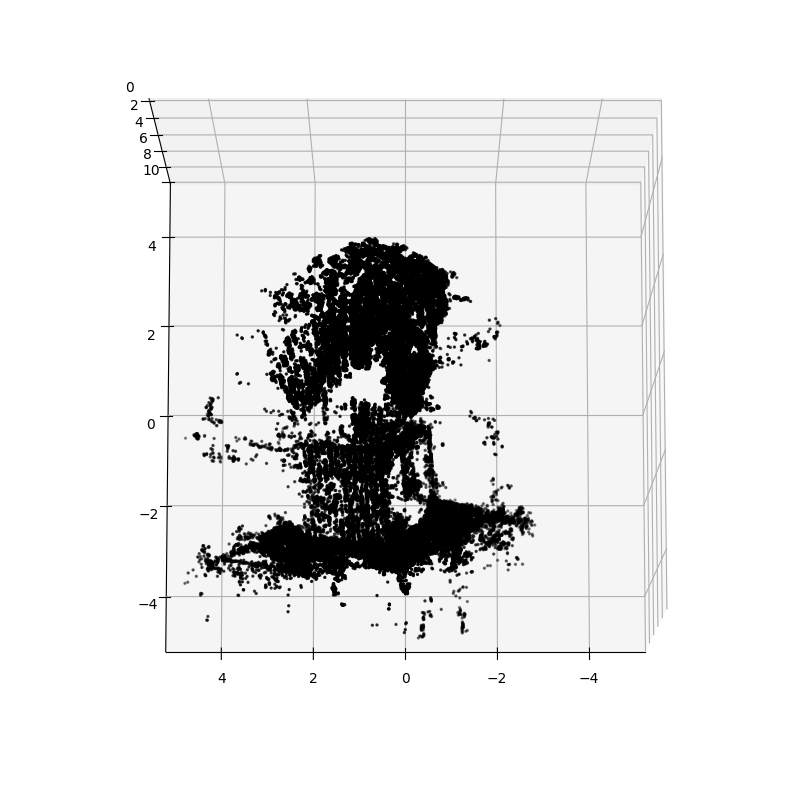

In [8]:
# PSET 2 Problem 4
import sys
import numpy as np
import os
from scipy.optimize import least_squares
import math
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.io import imread
import scipy.misc
# from sfm_utils import *

'''
ESTIMATE_INITIAL_RT from the Essential Matrix, we can compute 4 initial
guesses of the relative RT between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
Returns:
    RT: A 4x3x4 tensor in which the 3x4 matrix RT[i,:,:] is one of the
        four possible transformations
'''
def estimate_initial_RT(E):
    # TODO: Implement this method!
    U, d, vh = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    Q1 = U.dot(W).dot(vh)
    Q2 = U.dot(W.T).dot(vh)
    R1 = np.linalg.det(Q1) * Q1
    R2 = np.linalg.det(Q2) * Q2
    T1 = U[:, 2: 3]
    T2 = -U[:, 2: 3]
    RT = np.array([np.c_[R1, T1], np.c_[R1, T2], np.c_[R2, T1], np.c_[R2, T2]])
    return RT

'''
LINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point is the best linear estimate
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point
'''
def linear_estimate_3d_point(image_points, camera_matrices):
    # TODO: Implement this method!
    M = image_points.shape[0]
    A = np.zeros((2 * M, 4))
    for i in range(M):
        A[2 * i] = image_points[i, 0] * camera_matrices[i, 2, :] - camera_matrices[i, 0, :]
        A[2 * i + 1] = image_points[i, 1] * camera_matrices[i, 2, :] - camera_matrices[i, 1, :] 
    u, s, vh = np.linalg.svd(A)
    point_3d = vh[-1, :]
    point_3d = point_3d / point_3d[-1]
    return point_3d[0: -1]

'''
REPROJECTION_ERROR given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    error - the 2Mx1 reprojection error vector
'''
def reprojection_error(point_3d, image_points, camera_matrices):
    # TODO: Implement this method!
    P = np.r_[point_3d, 1]
    y = camera_matrices.dot(P)
    y /= y[:, 2:3]
    p_p = y[:, :2]
    error = (p_p - image_points).flatten()
    return error

'''
JACOBIAN given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    jacobian - the 2Mx3 Jacobian matrix
'''
def jacobian(point_3d, camera_matrices):
    # TODO: Implement this method!
    P1, P2, P3 = point_3d[0], point_3d[1], point_3d[2]
    M = camera_matrices.shape[0]
    jacobian = np.zeros((2*M, 3))
    for i in range(M):
        Mi = camera_matrices[i, :, :] # (3, 4)
        y1 = Mi[0, 0] * P1 + Mi[0, 1] * P2 + Mi[0, 2] * P3 + Mi[0, 3]
        y2 = Mi[1, 0] * P1 + Mi[1, 1] * P2 + Mi[1, 2] * P3 + Mi[1, 3]
        y3 = Mi[2, 0] * P1 + Mi[2, 1] * P2 + Mi[2, 2] * P3 + Mi[2, 3]
        jacobian[2*i, 0] = (Mi[0, 0] * y3 - y1 * Mi[2, 0]) / y3 ** 2
        jacobian[2*i, 1] = (Mi[0, 1] * y3 - y1 * Mi[2, 1]) / y3 ** 2
        jacobian[2*i, 2] = (Mi[0, 2] * y3 - y1 * Mi[2, 2]) / y3 ** 2
        jacobian[2*i+1, 0] = (Mi[1, 0] * y3 - y2 * Mi[2, 0]) / y3 ** 2
        jacobian[2*i+1, 1] = (Mi[1, 1] * y3 - y2 * Mi[2, 1]) / y3 ** 2
        jacobian[2*i+1, 2] = (Mi[1, 2] * y3 - y2 * Mi[2, 2]) / y3 ** 2
    return jacobian

'''
NONLINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point that iteratively updates the points
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point
'''
def nonlinear_estimate_3d_point(image_points, camera_matrices):
    # TODO: Implement this method!
    # P_t = P_t - (J.T * J)^-1 * J.T * e
    P_t = linear_estimate_3d_point(image_points, camera_matrices)
    for i in range(10):
        J = jacobian(P_t, camera_matrices)
        e = reprojection_error(P_t, image_points, camera_matrices)
        P_t -= np.linalg.inv(J.T.dot(J)).dot(J.T).dot(e)
    return P_t

'''
ESTIMATE_RT_FROM_E from the Essential Matrix, we can compute  the relative RT 
between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
    image_points - N measured points in each of the M images (NxMx2 matrix)
    K - the intrinsic camera matrix
Returns:
    RT: The 3x4 matrix which gives the rotation and translation between the 
        two cameras
'''
def estimate_RT_from_E(E, image_points, K):
    # TODO: Implement this method!
    RT = estimate_initial_RT(E)
    N = image_points.shape[0]
    for i in range(4):
        count = 0
        max_points = 0
        rt = RT[i, :, :]
        c1 = np.c_[K, np.zeros((3,1))]
        c2 = K.dot(rt)
        camera_matrices = np.array([c1, c2])
        for j in range(N):
            estimated_point = nonlinear_estimate_3d_point(image_points[j], camera_matrices)
            if (estimated_point[2]) > 0:
                count += 1
        if count > max_points:
            max_points = count
            correct_RT = RT[i, :, :]
    return correct_RT

'''
sfm_utils
'''
# A class that stores information about multiple views of the scene
class Frame:
    def __init__(self, matches, focal_length, F, im_width, im_height):
        self.focal_length = focal_length
        self.im_height = im_height
        self.im_width = im_width
        self.matches = matches

        self.N = matches.shape[0]
        self.match_idx = np.array([np.arange(self.N), 
            np.arange(self.N, 2 * self.N)])
        self.match_points = np.vstack((matches[:,:2], matches[:,2:]))

        self.K = np.eye(3)
        self.K[0,0] = self.K[1,1] = focal_length
        self.E = self.K.T.dot(F).dot(self.K)
        self.T = estimate_RT_from_E(self.E, matches.reshape((-1,2,2)), self.K)

        self.motion = np.zeros((2,3,4))
        self.motion[0,:,:-1] = np.eye(3)
        self.motion[1,:,:] = self.T
        self.structure = triangulate(self)

'''
NEG_ONES
Arguments:
    size - the dimensions of a tensor given as a tuple or array
    dtype - the numpy type of the tensor
Returns:
    neg_ones - similar to np.zeros or np.ones, but with -1
'''
def neg_ones(size, dtype = np.int16):
    return -1 * np.ones(size, dtype = dtype)

'''
TRIANGULATE
Arguments:
    frame - information about multiple views of the scene
Returns:
    structure - the 3D points of the scene
'''
def triangulate(frame):
    num_cameras, num_points = frame.match_idx.shape
    structure = np.zeros((num_points,3))
    all_camera_matrices = np.zeros((num_cameras, 3, 4))
    for i in range(num_cameras):
        all_camera_matrices[i,:,:] = frame.K.dot(frame.motion[i,:,:])
    for i in range(num_points):
        valid_cameras = np.where(frame.match_idx[:,i] >= 0)[0]
        camera_matrices = all_camera_matrices[valid_cameras,:,:]
        x = np.zeros((len(valid_cameras), 2))
        for ctr, c in enumerate(valid_cameras):
            x[ctr, :] = frame.match_points[frame.match_idx[c, i],:]
        structure[i,:] = nonlinear_estimate_3d_point(x, camera_matrices)

    return structure 

'''
ROTATION_MATRIX_TO_ANGLE_AXIS
Arguments:
    R - a rotation matrix
Returns:
    angle_axis - the angle axis representation of the rotation
'''
def rotation_matrix_to_angle_axis(R):
    angle_axis = np.array([0.0]*3)
    angle_axis[0] = R[2, 1] - R[1, 2]
    angle_axis[1] = R[0, 2] - R[2, 0]
    angle_axis[2] = R[1, 0] - R[0, 1]
    
    cos_theta = min(max((R[0,0]+R[1,1]+R[2,2] - 1.0) / 2.0, -1.0), 1.0)
    sin_theta = min(np.sqrt((angle_axis**2).sum())/2, 1.0);

    theta = math.atan2(sin_theta, cos_theta)

    k_threshold = 1e-12
    if ((sin_theta > k_threshold) or (sin_theta < -k_threshold)):
        r = theta / (2.0 * sin_theta)
        angle_axis = angle_axis * r
        return angle_axis

    if cos_theta > 0:
        angle_axis = angle_axis / 2
        return angle_axis

    inv_one_minus_cos_theta = 1.0 / (1.0 - cos_theta)

    for i in range(3):
        angle_axis[i] = theta * math.sqrt((R[i,i] - cos_theta) 
            * inv_one_minus_cos_theta)
        if((sin_theta < 0 and angle_axis[i] > 0) or
            (sin_theta > 0 and angle_axis[i] < 0)):
            angle_axis[i] *= -1

    return angle_axis

'''
ROTATION_MATRIX_TO_ANGLE_AXIS
Arguments:
    angle_axis - the angle axis representation of the rotation
Returns:
    R - the corresponding rotation matrix
'''
def angle_axis_to_rotation_matrix(angle_axis):
    theta2 = np.dot(angle_axis, angle_axis)
    R = np.zeros((3,3))
    if theta2 > 0:
        theta = np.sqrt(theta2)
        wx, wy, wz = tuple(angle_axis / theta)
        cos_theta = math.cos(theta)
        sin_theta = math.sin(theta)
        R[0, 0] = cos_theta + wx * wx * (1 - cos_theta)
        R[1, 0] = wz * sin_theta + wx * wy * (1 - cos_theta)
        R[2, 0] = -wy * sin_theta + wx * wz * (1 - cos_theta)
        R[0, 1] =  wx * wy * (1 - cos_theta) - wz * sin_theta;
        R[1, 1] = cos_theta   + wy * wy * (1 - cos_theta);
        R[2, 1] =  wx * sin_theta   + wy * wz * (1 - cos_theta);
        R[0, 2] =  wy * sin_theta   + wx * wz * (1 - cos_theta);
        R[1, 2] = -wx * sin_theta   + wy * wz * (1 - cos_theta);
        R[2, 2] = cos_theta   + wz * wz * (1 - cos_theta);

    else:
        # At zero, we switch to using the first order Taylor expansion.
        R[0, 0] =  1;
        R[1, 0] = -angle_axis[2];
        R[2, 0] =  angle_axis[1];
        R[0, 1] =  angle_axis[2];
        R[1, 1] =  1;
        R[2, 1] = -angle_axis[0];
        R[0, 2] = -angle_axis[1];
        R[1, 2] =  angle_axis[0];
        R[2, 2] = 1;
    return R

'''
CROSS_PRODUCT_MAT
Arguments:
    a - a 3x1 vector
Returns:
    m - the corresponding cross-product matrix [a]_x
'''
def cross_product_mat(a):
    m = np.zeros((3,3))
    m[1,0] = a[2]
    m[0,1] = -a[2]
    m[2,0] = -a[1]
    m[0,2] = a[1]
    m[2,1] = a[0]
    m[1,2] = -a[0]
    return m

'''
ANGLE_AXIS_ROTATE
Arguments:
    angle_axis - the angle axis representation of the rotation
    pt - a matrix containing points
Returns:
    new_pts - a matrix containing the points after the rotation is applied
'''
def angle_axis_rotate(angle_axis, pt):
    aa = angle_axis[:3].reshape((1,3))
    theta2 = aa.dot(aa.T)[0,0]
    if theta2 > 0:
        theta = np.sqrt(theta2)
        w = aa / theta
        cos_theta = math.cos(theta)
        sin_theta = math.sin(theta)

        w_cross_pt = cross_product_mat(w[0]).dot(pt)

        w_dot_pt = w.dot(pt)

        result = pt * cos_theta + w_cross_pt * sin_theta + (w.T * (1 - cos_theta)).dot(w_dot_pt)
    else:
        w_cross_pt = cross_product_mat(aa[0,:]).dot(pt)
        result = pt + w_cross_pt
    return result
        

'''
REPROJECTION_ERROR_MOT_STR
Arguments:
    match_idx - a MxN matrix corresponding to what indices of the match_points
        are visible in each of the M cameras
    match_points - the pixel locations in the image
    f - the focal length
    px - the principal component in the x direction
    py - the principal component in the y direction
    motion - the camera's motion tensor
    structure - the current 3D point estimate of the scene
Returns:
    errors - the reprojection error vector
'''
def reprojection_error_mot_str(match_idx, match_points, f, px, py, motion, structure):
    N = match_idx.shape[0]

    errors = None
    for i in range(N):
        valid_pts = match_idx[i,:] >= 0
        valid_idx = match_idx[i, valid_pts]

        RP = angle_axis_rotate(motion[i, :, 0], structure[valid_pts,:].T)

        TRX = RP[0, :] + motion[i, 0, 1]
        TRY = RP[1, :] + motion[i, 1, 1]
        TRZ = RP[2, :] + motion[i, 2, 1]

        TRXoZ = TRX / TRZ
        TRYoZ = TRY / TRZ
        
        x = f * TRXoZ + px
        y = f * TRYoZ + py

        ox = match_points[valid_idx, 0]
        oy = match_points[valid_idx, 1]

        if errors is None:
            errors = np.vstack((x-ox, y-oy))
        else:
            errors = np.hstack((errors, np.vstack((x-ox, y-oy))))

    return errors.flatten()
'''
REPROJECTION_ERROR_MOT_STR_OPT
Arguments:
    mot_str - the motion and structure matrices flattened into one vector
        this allows us to use the builtin nonlinear optimization methods
    match_idx - a MxN matrix corresponding to what indices of the match_points
        are visible in each of the M cameras
    match_points - the pixel locations in the image
    f - the focal length
    px - the principal component in the x direction
    py - the principal component in the y direction
Returns:
    errors - the reprojection error vector
'''
def reprojection_error_mot_str_opt(mot_str, match_idx, match_points, f, px, py):
    num_cameras = match_idx.shape[0]
    cut = 3 * 2 * num_cameras
    structure = mot_str[cut:].reshape((-1,3))
    motion = mot_str[:cut].reshape((-1,3,2))

    error = reprojection_error_mot_str(match_idx, match_points, f, px, py, motion, structure)
    return error

'''
BUNDLE_ADJUSTMENT
Arguments:
    frame - the information about multiple views of the scene
Returns:
    Nothing; updates the motion and structure information
'''
def bundle_adjustment(frame):
    num_cameras = frame.motion.shape[0]
    motion_angle_axis = np.zeros((num_cameras, 3, 2))
    for i in range(num_cameras):
        motion_angle_axis[i, :, 0] = rotation_matrix_to_angle_axis(
                frame.motion[i,:, :-1])
        motion_angle_axis[i, :, 1] = frame.motion[i, :, -1]

    px = 0
    py = 0
    
    errors = reprojection_error_mot_str(frame.match_idx, frame.match_points, frame.focal_length, px, py, motion_angle_axis, frame.structure)

    vec = least_squares(reprojection_error_mot_str_opt, np.hstack((motion_angle_axis.flatten(), frame.structure.flatten())),
        args=(frame.match_idx, frame.match_points, frame.focal_length, px, py), method='lm')

    cut = 3 * 2 * num_cameras

    opt_val = vec['x']
    frame.structure = opt_val[cut:].reshape((-1,3))
    motion_angle_axis = opt_val[:cut].reshape((-1, 3, 2))

    for i in range(num_cameras):
        frame.motion[i,:,:] = np.hstack((angle_axis_to_rotation_matrix(motion_angle_axis[i,:,0]), motion_angle_axis[i,:,1].reshape((3,1))))

'''
MULTIPLY_TRANSFORMATIONS
Arguments:
    A - a matrix
    B - another matrix
Returns:
    M - the matrix that occurs when you rotate B by A's rotation component
        and then translate by A's translation component
'''
def multiply_transformations(A, B):
    return np.hstack((A[:,:3].dot(B[:,:3]), (A[:,:3].dot(B[:,-1]) + A[:,-1]).reshape((3,-1))))

'''
INVERSE
Arguments:
    x - a 3x4 matrix that assumes only rotation and translation
Returns:
    inv_x - the 3x4 matrix inverse of x
'''
def inverse(x):
    return np.hstack((x[:3, :3].T, -x[:3, :3].T.dot(x[:3, -1]).reshape((3,-1))))

'''
TRANSFORM_POINTS
Arguments:
    points_3d - 3d points listed as a 3xN matrix
    Rt - the 3x4 transformation matrix
    is_inverse - whether to use the inverted Rt or non-inverted
Returns:
    new_points - the points after applying the Rt
'''
def transform_points(points_3d, Rt, is_inverse = False):
    if is_inverse:
        return Rt[:,:3].T.dot((points_3d - Rt[:,-1]).T).T
    return Rt[:,:3].dot(points_3d.T).T + Rt[:,-1]

'''
ROW_INTERSECTION
Arguments:
    A - a matrix
    B - another matrix
Returns:
    intersect - a matrix whose rows are both rows in A and B
    idA - indices of these rows in A
    idB - indices of these rows in B
'''
def row_intersection(A, B):
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
                   'formats':ncols * [A.dtype]}
    intersect = np.intersect1d(A.view(dtype), B.view(dtype))
    intersect = intersect.view(A.dtype).reshape((-1,ncols))
    idA = np.array([np.where(np.all(A==x, axis=1))[0][0] for x in intersect])
    idB = np.array([np.where(np.all(B==x, axis=1))[0][0] for x in intersect])
    return intersect, idA, idB

'''
ROW_SET_DIFF
Arguments:
    A - a matrix
    B - another matrix
Returns:
    set_diff - a matrix whose rows are only in one of A or B
    idA - indices of these rows in A
    idB - indices of these rows in B
'''
def row_set_diff(A, B):
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
                   'formats':ncols * [A.dtype]}
    set_diff = np.setdiff1d(A.view(dtype), B.view(dtype))
    set_diff = set_diff.view(A.dtype).reshape((-1,ncols))
    idA = []
    idB = []
    for x in set_diff:
        idx_in_A = np.where(np.all(A==x, axis=1))[0]
        idx_in_B = np.where(np.all(B==x, axis=1))[0]
        if len(idx_in_A) != 0:
            idA.append(idx_in_A[0])
        if len(idx_in_B) != 0:
            idB.append(idx_in_B[0])

    return set_diff, np.array(idA), np.array(idB)

'''
REMOVE_OUTLIERS
Arguments:
    frame - the information about multiple views of the scene
    threshold - a threshold for the sum square of the reprojection error
Returns:
    Nothing; updated frame information (structure)
'''
def remove_outliers(frame, threshold = 10.0):
    threshold *= threshold
    threshold_in_degree = 2.0
    threshold_in_cos = math.cos(float(threshold_in_degree) / 180 * math.pi)

    for i in range(frame.match_idx.shape[0]):
        X = frame.K.dot(transform_points(frame.structure, frame.motion[i,:,:]).T)
        xy = X[:2, :] / X[2, :]
        selector = np.where(frame.match_idx[i,:] >= 0)[0]
        diff = xy[:, selector].T - frame.match_points[frame.match_idx[i, selector],:]
        outliers = np.sum(diff**2, axis=1) > threshold
        
        pts2keep = np.array([True] * frame.structure.shape[0])
        pts2keep[selector[outliers]] = False

        frame.structure = frame.structure[pts2keep, :]
        frame.match_idx = frame.match_idx[:, pts2keep]

    # check viewing angle
    num_frames = frame.motion.shape[0]
    positions = np.zeros((3, num_frames))
    for i in range(num_frames):
        Rt = frame.motion[i, : , :]
        positions[:, i] = -Rt[:3, :3].T.dot(Rt[:,-1])
    
    view_dirs = np.zeros((3, frame.structure.shape[0], num_frames))
    for i in range(frame.match_idx.shape[0]-1):
        selector = np.where(frame.match_idx[i,:] >= 0)[0]
        camera_view_dirs = frame.structure[selector,:] - positions[:, i]
        dir_length = np.sqrt(np.sum(camera_view_dirs ** 2))
        camera_view_dirs = camera_view_dirs / dir_length
        view_dirs[:, selector, i] = camera_view_dirs.T

    for c1 in range(num_frames):
        for c2 in range(c1,num_frames):
            if c1 == c2: continue
            selector1 = np.where(frame.match_idx[c1,:] >= 0)[0]
            selector2 = np.where(frame.match_idx[c2,:] >= 0)[0]
            selector = np.array([x for x in selector1 if x in selector2])
            if len(selector) == 0:
                continue
            view_dirs_1 = view_dirs[:, selector, c1]
            view_dirs_2 = view_dirs[:, selector, c2]
            cos_angles = np.sum(view_dirs_1 * view_dirs_2, axis=0)
            outliers = cos_angles > threshold_in_cos

            pts2keep = np.array([True] * frame.structure.shape[0])
            pts2keep[selector[outliers]] = False
            frame.structure = frame.structure[pts2keep, :]
            frame.match_idx = frame.match_idx[:,pts2keep]

'''
MERGE_TWO_FRAMES
Arguments:
    frameA - a frame 
    frameB - another frame, we assume the first index of frameB corresponds to
        the last camera index of frameA
    length - the number of total cameras
Returns:
    merged_frame - the merged information of both frames
'''
def merge_two_frames(frameA, frameB, length):
    merged_frame = deepcopy(frameA)

    frameB_to_A = multiply_transformations(inverse(frameA.motion[-1,:,:]), frameB.motion[0,:,:])
    frameB.structure = transform_points(frameB.structure, frameB_to_A)
    for i in range(2):
        frameB.motion[i,:,:] = multiply_transformations(frameB.motion[i,:,:], inverse(frameB_to_A))

    # since camera is in merged reference frame, add it to motion matrix
    merged_frame.motion = np.vstack((merged_frame.motion, frameB.motion[-1,:,:].reshape((-1,3,4))))

    # we need to reconcile the matched points to generate the structure.
    # we need to merge the matched_points from each additional frame, but must 
    # associate points that correspond to already seen points in the same
    # column
    trA = np.where(frameA.match_idx[0,:] >= 0)[0]
    xyA = frameA.match_points[frameA.match_idx[-1, trA], :]

    trB = np.where(frameB.match_idx[0,:] >= 0)[0]
    xyB = frameB.match_points[frameB.match_idx[0, trB], :]

    xy_common, iA, iB = row_intersection(xyA, xyB)
    xy_common = xy_common.T

    merged_frame.match_idx = np.vstack((merged_frame.match_idx, neg_ones((1, merged_frame.match_idx.shape[1]))))
    for i in range(xy_common.shape[1]):
        idA = trA[iA[i]]
        idB = trB[iB[i]]

        B_match_idx = frameB.match_idx[1, idB]

        merged_frame.match_points = np.vstack((merged_frame.match_points, frameB.match_points[B_match_idx, :]))
        merged_frame.match_idx[length, idA] = merged_frame.match_points.shape[0]-1

    # One of the cameras in frame B is the same as frame A
    # We will add all new points from this camera into the match fields
    xy_new, iB, iA = row_set_diff(xyB, xyA)
    xy_new = xy_new.T

    for i in range(xy_new.shape[1]):
        idB = trB[iB[i]]

        merged_frame.match_points = np.vstack((merged_frame.match_points,frameB.match_points[frameB.match_idx[0,idB],:]))
        merged_frame.match_idx = np.hstack((merged_frame.match_idx, neg_ones((merged_frame.match_idx.shape[0],1))))
        merged_frame.match_idx[length-1,-1] = merged_frame.match_points.shape[0]-1
        merged_frame.structure = np.vstack((merged_frame.structure, frameB.structure[idB,:]))

        B_match_idx = frameB.match_idx[1, idB]

        merged_frame.match_points = np.vstack((merged_frame.match_points, frameB.match_points[B_match_idx,:]))
        merged_frame.match_idx[length,-1] = merged_frame.match_points.shape[0]-1

    # The other camera in frame B is new
    # We can simply add all the points from here
    # TODO: This part is not implemented currently, but a full SFM pipeline should have it 

    return merged_frame

'''
MERGE_ALL_FRAMES
Arguments:
    frames - a list of frames
Returns:
    merged_frame - a frame which contains the information of all the frames
'''
def merge_all_frames(frames):
    merged_frame = deepcopy(frames[0])
    for i in range(1,len(frames)):
        merged_frame = merge_two_frames(merged_frame, frames[i], i+1)
        merged_frame.structure = triangulate(merged_frame)
        bundle_adjustment(merged_frame)
        remove_outliers(merged_frame, 10)
        bundle_adjustment(merged_frame)

    return merged_frame



if __name__ == '__main__':
    run_pipeline = True

    # Load the data
    image_data_dir = 'data/statue/'
    unit_test_camera_matrix = np.load('data/unit_test_camera_matrix.npy')
    unit_test_image_matches = np.load('data/unit_test_image_matches.npy')
    image_paths = [os.path.join(image_data_dir, 'images', x) for x in
        sorted(os.listdir('data/statue/images')) if '.jpg' in x]
    focal_length = 719.5459
    matches_subset = np.load(os.path.join(image_data_dir,
        'matches_subset.npy'), allow_pickle=True, encoding='latin1')[0,:]
    dense_matches = np.load(os.path.join(image_data_dir, 'dense_matches.npy'), 
                               allow_pickle=True, encoding='latin1')
    fundamental_matrices = np.load(os.path.join(image_data_dir,
        'fundamental_matrices.npy'), allow_pickle=True, encoding='latin1')[0,:]

    # Part A: Computing the 4 initial R,T transformations from Essential Matrix
    print('-' * 80)
    print("Part A: Check your matrices against the example R,T")
    print('-' * 80)
    K = np.eye(3)
    K[0,0] = K[1,1] = focal_length
    E = K.T.dot(fundamental_matrices[0]).dot(K)
    im0 = imread(image_paths[0])
    im_height, im_width, _ = im0.shape
    example_RT = np.array([[0.9736, -0.0988, -0.2056, 0.9994],
        [0.1019, 0.9948, 0.0045, -0.0089],
        [0.2041, -0.0254, 0.9786, 0.0331]])
    print("Example RT:\n", example_RT)
    estimated_RT = estimate_initial_RT(E)
    print('')
    print("Estimated RT:\n", estimated_RT)

    # Part B: Determining the best linear estimate of a 3D point
    print('-' * 80)
    print('Part B: Check that the difference from expected point ')
    print('is near zero')
    print('-' * 80)
    camera_matrices = np.zeros((2, 3, 4))
    camera_matrices[0, :, :] = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))
    camera_matrices[1, :, :] = K.dot(example_RT)
    unit_test_matches = matches_subset[0][:,0].reshape(2,2)
    estimated_3d_point = linear_estimate_3d_point(unit_test_matches.copy(),
        camera_matrices.copy())
    expected_3d_point = np.array([0.6774, -1.1029, 4.6621])
    print("Difference: ", np.fabs(estimated_3d_point - expected_3d_point).sum())

    # Part C: Calculating the reprojection error and its Jacobian
    print('-' * 80)
    print('Part C: Check that the difference from expected error/Jacobian ')
    print('is near zero')
    print('-' * 80)
    estimated_error = reprojection_error(
            expected_3d_point, unit_test_matches, camera_matrices)
    estimated_jacobian = jacobian(expected_3d_point, camera_matrices)
    expected_error = np.array((-0.0095458, -0.5171407,  0.0059307,  0.501631))
    print("Error Difference: ", np.fabs(estimated_error - expected_error).sum())
    expected_jacobian = np.array([[ 154.33943931, 0., -22.42541691],
         [0., 154.33943931, 36.51165089],
         [141.87950588, -14.27738422, -56.20341644],
         [21.9792766, 149.50628901, 32.23425643]])
    print("Jacobian Difference: ", np.fabs(estimated_jacobian
        - expected_jacobian).sum())

    # Part D: Determining the best nonlinear estimate of a 3D point
    print('-' * 80)
    print('Part D: Check that the reprojection error from nonlinear method')
    print('is lower than linear method')
    print('-' * 80)
    estimated_3d_point_linear = linear_estimate_3d_point(
        unit_test_image_matches.copy(), unit_test_camera_matrix.copy())
    estimated_3d_point_nonlinear = nonlinear_estimate_3d_point(
        unit_test_image_matches.copy(), unit_test_camera_matrix.copy())
    error_linear = reprojection_error(
        estimated_3d_point_linear, unit_test_image_matches,
        unit_test_camera_matrix)
    print("Linear method error:", np.linalg.norm(error_linear))
    error_nonlinear = reprojection_error(
        estimated_3d_point_nonlinear, unit_test_image_matches,
        unit_test_camera_matrix)
    print("Nonlinear method error:", np.linalg.norm(error_nonlinear))

    # Part E: Determining the correct R, T from Essential Matrix
    print('-' * 80)
    print("Part E: Check your matrix against the example R,T")
    print('-' * 80)
    estimated_RT = estimate_RT_from_E(E,
        np.expand_dims(unit_test_image_matches[:2,:], axis=0), K)
    print("Example RT:\n", example_RT)
    print('')
    print("Estimated RT:\n", estimated_RT)

    # Part F: Run the entire Structure from Motion pipeline
    if not run_pipeline:
        sys.exit()
    print('-' * 80)
    print('Part F: Run the entire SFM pipeline')
    print('-' * 80)
    frames = [0] * (len(image_paths) - 1)
    for i in range(len(image_paths)-1):
        frames[i] = Frame(matches_subset[i].T, focal_length,
                fundamental_matrices[i], im_width, im_height)
        bundle_adjustment(frames[i])
    merged_frame = merge_all_frames(frames)

    # Construct the dense matching
    camera_matrices = np.zeros((2,3,4))
    dense_structure = np.zeros((0,3))
    for i in range(len(frames)-1):
        matches = dense_matches[i]
        camera_matrices[0,:,:] = merged_frame.K.dot(
            merged_frame.motion[i,:,:])
        camera_matrices[1,:,:] = merged_frame.K.dot(
                merged_frame.motion[i+1,:,:])
        points_3d = np.zeros((matches.shape[1], 3))
        use_point = np.array([True]*matches.shape[1])
        for j in range(matches.shape[1]):
            points_3d[j,:] = nonlinear_estimate_3d_point(
                matches[:,j].reshape((2,2)), camera_matrices)
        dense_structure = np.vstack((dense_structure, points_3d[use_point,:]))

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.scatter(dense_structure[:,0], dense_structure[:,1], dense_structure[:,2],
        c='k', depthshade=True, s=2)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(0, 10)
    ax.view_init(-100, 90)

    plt.show()

That's it, you are done! Remember to submit your code by copying the code from Colab to p[X].py, and submitting it to Gradescope by zipping the .py files and uploading the zip file to the coding assignment.

